This notebook is to manually check the computation of particular parts of the optimization.
1. Checking for descent direction
2. Checking at what happens to forward model and w vector when transformed by $L^{-1}$

In [1]:
import numpy as np
import pickle
from scipy import stats

# Objective function of $w$ optimization

The objective function has the form
\begin{equation}
    -w^T y + \psi_\alpha \lVert w \rVert_2 - \lambda_k^T K^T w + \frac{\mu}{2} \lVert K^T w \rVert_2^2 - \mu (h + A^T c_k)^T K^T w,
\end{equation}
which to start is equivalent to
\begin{equation}
    -w^T y + \psi_\alpha \lVert w \rVert_2 + \frac{\mu}{2} \lVert K^T w \rVert_2^2 - \mu h^T K^T w,
\end{equation}
since $\lambda_k = c_k = 0$.

As such, I need the following items
1. $w$ --> generated by Gaussian with known random seed
2. $y$ --> affine corrected observation
3. $\psi_\alpha$ --> on Cheyenne
4. $\mu$ --> fixed up front
5. $K^T w$ --> saved in the hash table
6. $h$ --> functional

In [2]:
# affine corrected observation
with open('../data/y_affine_corrected.npy', 'rb') as f:
    y = np.load(f)
m = y.shape[0]
print(y[:10])

[-0.43160245  1.55670918 -0.19545318  1.94694523  1.20822325 -0.39844148
 -1.67594377  0.46664634  0.93883433  2.17580318]


In [3]:
# Gaussian vector
np.random.seed(12345)
w_sp = stats.norm().rvs(m)
print(w_sp[:10])

# make hash value for the above
w_key = hash(w_sp.tobytes())
print(w_key)

[-0.20470766  0.47894334 -0.51943872 -0.5557303   1.96578057  1.39340583
  0.09290788  0.28174615  0.76902257  1.24643474]
3593246642627272539


In [4]:
# slack factor
with open('../data/opt_res_cont.pkl', 'rb') as f:
    opt_slack = pickle.load(f)
PSI2 = stats.chi2.ppf(q=.95, df=1) + opt_slack[1]
psi_alpha = np.sqrt(PSI2)
print(psi_alpha)

145.0614723275884


In [5]:
# table of K^T evals
with open('../data/h_table_lep.pkl', 'rb') as f:
    KTw_dict = pickle.load(f)

In [6]:
# functional
with open('../data/na_june_functional.npy', 'rb') as f:
    h = np.load(f)

In [7]:
# isolate the keys
dict_keys = list(KTw_dict.keys())
print(dict_keys)

[0, -8025139033159738307, -7350210967711714390, 5107400654505320952, -6967323695701719286]


In [8]:
w_diff = w_sp - KTw_dict[-8025139033159738307]['w']
w_diff[w_diff > 0]

array([2.22044605e-16, 3.46944695e-18, 2.22044605e-16, 5.55111512e-17])

In [9]:
def obj_func(w, y, psi, mu, KTw, h):
    t1 = -np.dot(w, y)
    t2 = psi * np.linalg.norm(w)
    t3 = (mu / 2) * np.dot(KTw, KTw)
    t4 = - mu * np.dot(h, KTw)
    return t1 + t2 + t3 + t4

In [10]:
# objective function at the start (idx 1)
KEY_IDX = 1
MU = 1e3
obj_func(
    w=KTw_dict[dict_keys[KEY_IDX]]['w'],
    y=y, psi=psi_alpha, mu=MU,
    KTw=KTw_dict[dict_keys[KEY_IDX]]['KTw'], h=h
)

23980.77548636149

In [11]:
# objective function at the start (idx 2)
KEY_IDX = 2
MU = 1e3
obj_func(
    w=KTw_dict[dict_keys[KEY_IDX]]['w'],
    y=y, psi=psi_alpha, mu=MU,
    KTw=KTw_dict[dict_keys[KEY_IDX]]['KTw'], h=h
)

24069.30741486912

In [12]:
# objective function at the start (idx 3)
KEY_IDX = 3
MU = 1e3
obj_func(
    w=KTw_dict[dict_keys[KEY_IDX]]['w'],
    y=y, psi=psi_alpha, mu=MU,
    KTw=KTw_dict[dict_keys[KEY_IDX]]['KTw'], h=h
)

23997.29170224255

In [13]:
# objective function at the start (idx 4)
KEY_IDX = 4
MU = 1e3
obj_func(
    w=KTw_dict[dict_keys[KEY_IDX]]['w'],
    y=y, psi=psi_alpha, mu=MU, 
    KTw=KTw_dict[dict_keys[KEY_IDX]]['KTw'], h=h
)

23983.866795435646

# Checking out $Kc \to L^{-1}Kc$ and $w \to L^{-1} w$

Using some code from `~/Research/Carbon_Flux/optimization/testing_adjoint_affine_correct_default_init.ipynb`

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

#### $L^{-1} Kc$

In [16]:
# read in the GOSAT data
BASE_PATH = '/Users/mikestanley/Research/Carbon_Flux'
GOSAT_DF_FP = BASE_PATH + '/data/generated_gosat/gosat_df_jan1_aug31_2010.csv'
gosat_df = pd.read_csv(GOSAT_DF_FP)
print(gosat_df.head())

   Unnamed: 0  lgos     lon     lat   psurf    xco2  xco2_unc    year  month  \
0           0  20.0  164.43 -32.746  1022.4  385.59   1.80280  2010.0    1.0   
1           1  20.0  166.49 -25.096  1017.6  387.60   0.87912  2010.0    1.0   
2           2  20.0  166.92 -23.364  1016.1  385.91   1.80280  2010.0    1.0   
3           3  20.0  167.58 -20.674  1014.1  388.07   1.80280  2010.0    1.0   
4           4  20.0  168.16 -18.253  1012.6  387.36   1.80280  2010.0    1.0   

   day  ohour  omin  osec  gcpsurf  xco2_unce  lon_idx  lat_idx        date  \
0  1.0    1.0   0.0   0.0  1016.00  -0.256480       69       14  2010-01-01   
1  1.0    1.0   0.0   0.0  1019.70   1.290160       69       16  2010-01-01   
2  1.0    1.0   0.0   0.0  1017.58   0.986204       69       17  2010-01-01   
3  1.0    1.0   0.0   0.0  1018.41   1.216930       70       17  2010-01-01   
4  1.0    1.0   0.0   0.0  1014.04   0.237283       70       18  2010-01-01   

   date_str  date_idx  
0  20100101         

In [22]:
# construct the L^{-1} matrix
L_inv_vec = 1 / gosat_df.xco2_unc.values
print(L_inv_vec.shape)

(28267,)


In [23]:
# read in some forward model input
with open(BASE_PATH + '/data/testing_adjoint_data/test_17/xco2_modeled.txt', 'rb') as f:
    f_c = np.loadtxt(f)

# scale appropriately
f_c = f_c * 1e6
    
# flip so going from oldest to newest observations
f_c = np.flip(f_c)

print(f_c[:10])
print(f_c.sum())

[386.02160098 386.04329082 386.10872858 386.1235663  386.15169259
 385.96844148 385.74438083 386.15837212 386.44930512 386.51587296]
10976017.476663776


In [24]:
# read in the affine correction
with open('../data/affine_correction.npy', 'rb') as f:
    b = np.load(f)
print(b[:10])

[386.02160245 386.04329082 386.10545318 386.12305477 386.15177675
 385.96844148 385.73594377 386.15335366 386.45116567 386.51419682]


In [25]:
# define Kx = f(c) - b
Kx = f_c - b
print(Kx[:10])

[-1.47086229e-06  0.00000000e+00  3.27539496e-03  5.11527617e-04
 -8.41622449e-05  0.00000000e+00  8.43706529e-03  5.01846296e-03
 -1.86054963e-03  1.67614809e-03]


In [27]:
# find L^{-1} Kx
L_inv_Kx = np.multiply(L_inv_vec, Kx)

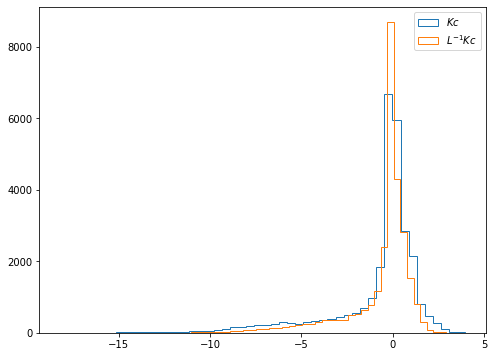

In [30]:
plt.figure(figsize=(8, 6))
plt.hist(Kx, bins=50, histtype='step', label=r'$Kc$')
plt.hist(L_inv_Kx, bins=50, histtype='step', label=r'$L^{-1} Kc$')
plt.legend()
plt.show()

### $L^{-1} w$

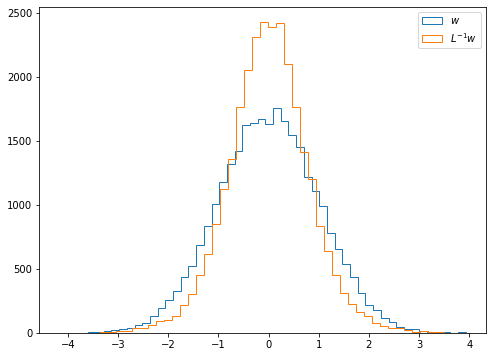

In [31]:
w_orig = KTw_dict[dict_keys[1]]['w']
w_L_inv = np.multiply(L_inv_vec, w_orig)

plt.figure(figsize=(8, 6))
plt.hist(w_orig, bins=50, histtype='step', label=r'$w$')
plt.hist(w_L_inv, bins=50, histtype='step', label=r'$L^{-1} w$')
plt.legend()
plt.show()